Import packages

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models
from torchvision.transforms import v2
from torcheval.metrics.functional import multiclass_f1_score
from collections import Counter
from tqdm import tqdm

Load and transform data

In [2]:
path = 'train/simpsons_dataset/'
transform = v2.Compose([
    v2.Resize((256, 256)),
    v2.CenterCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float, scale=True),
    # v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
data = datasets.ImageFolder(path, transform=transform)
data

Dataset ImageFolder
    Number of datapoints: 20933
    Root location: train/simpsons_dataset/
    StandardTransform
Transform: Compose(
                 Resize(size=[256, 256], interpolation=InterpolationMode.BILINEAR, antialias=warn)
                 CenterCrop(size=(224, 224))
                 ToImage()
                 ToDtype(scale=True)
                 Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
           )

Split data to training and test subsets

In [3]:
y = np.array([i[1] for i in data])
y

array([ 0,  0,  0, ..., 41, 41, 41])

In [4]:
train_data, test_data = train_test_split(np.arange(len(data)), test_size=0.25, stratify=y, random_state=42)
train_data

array([15895, 14197,  3968, ...,  9963, 19807,  3183])

In [5]:
train_data = Subset(data, train_data)
test_data = Subset(data, test_data)
test_data

Use GPU if available

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


Check if data is imbalanced

<Axes: >

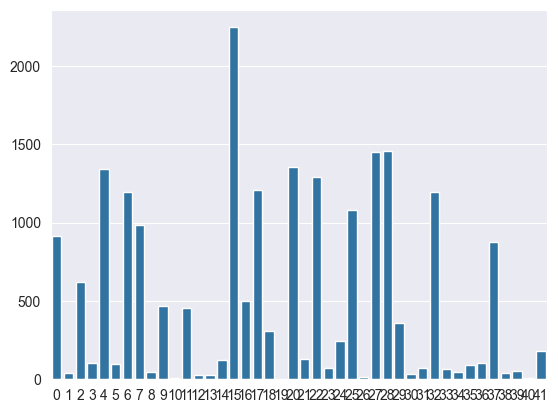

In [7]:
sns.barplot(data=Counter(y))

Get weights for each class, because data is imbalanced

In [8]:
weight = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
weight = torch.tensor(weight).to(torch.float).to(device)
weight

tensor([  0.5459,  11.8668,   0.8000,   4.7019,   0.3714,   5.0858,   0.4178,
          0.5055,  10.6044,   1.0627,  62.3006,   1.0906,  18.4594,  18.4594,
          4.1190,   0.2219,   1.0008,   0.4133,   1.6078, 166.1349,   0.3681,
          3.8938,   0.3861,   7.0198,   2.0260,   0.4619,  29.3179,   0.3433,
          0.3428,   1.3922,  15.5751,   6.9223,   0.4174,   7.6678,  11.0757,
          5.6001,   4.8389,   0.5683,  12.4601,   9.0619,  62.3006,   2.7536],
       device='mps:0')

Prepare data for fitting

In [9]:
batch_size = 64
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.int64


In [10]:
# batch_size = 64
# dataloader = DataLoader(data, batch_size=batch_size)
# for X, y in dataloader:
#     print(f"Shape of X [N, C, H, W]: {X.shape}")
#     print(f"Shape of y: {y.shape} {y.dtype}")
#     break

Make class of CNN

In [11]:
# class CNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.cnn = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=16, kernel_size=4, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=4),
#             nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=4),
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=4)
#         )
#         self.mpl = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(in_features=64 * 3 * 3, out_features=4096, bias=True),
#             nn.ReLU(),
#             nn.Linear(in_features=4096, out_features=4096, bias=True),
#             nn.ReLU(),
#             nn.Linear(in_features=4096, out_features=42, bias=True),
#             # nn.Softmax(dim=1)
#         )
# 
#     def forward(self, x):
#         x = self.cnn(x)
#         # print(x.shape)
#         x = self.mpl(x)
#         return x
# 
# 
# model = CNN().to(device)
# model

In [12]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(in_features=512, out_features=42, bias=True)
model = model.to(device)
model.eval()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Create train function

In [13]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    train_loss, correct = 0, 0
    y_pred = torch.zeros((len(dataloader) * batch_size), dtype=torch.long).to(device)
    y_true = torch.zeros((len(dataloader) * batch_size), dtype=torch.long).to(device)
    num_elements = 0
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = pred.argmax(1)
        y_pred[batch * batch_size:batch * batch_size + pred.shape[-1]] = pred
        y_true[batch * batch_size:batch * batch_size + y.shape[-1]] = y
        num_elements += y.shape[-1]
    train_loss /= len(dataloader)
    y_pred = y_pred[:num_elements]
    y_true = y_true[:num_elements]
    f1_score = multiclass_f1_score(y_pred, y_true)
    print(f"Train Error:\nF1: {f1_score:>8f}\nAvg loss: {train_loss:>8f}\n")
    return [f1_score.item(), train_loss]

Create test function

In [14]:
def test(dataloader, model, loss_fn):
    model.eval()
    test_loss = 0
    y_pred = torch.zeros((len(dataloader) * batch_size), dtype=torch.long).to(device)
    y_true = torch.zeros((len(dataloader) * batch_size), dtype=torch.long).to(device)
    num_elements = 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(tqdm(dataloader)):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            pred = pred.argmax(1)
            y_pred[batch * batch_size:batch * batch_size + pred.shape[-1]] = pred
            y_true[batch * batch_size:batch * batch_size + y.shape[-1]] = y
            num_elements += y.shape[-1]
    test_loss /= len(dataloader)
    y_pred = y_pred[:num_elements]
    y_true = y_true[:num_elements]
    f1_score = multiclass_f1_score(y_pred, y_true)
    print(f"Test Error:\nF1: {f1_score:>8f}\nAvg loss: {test_loss:>8f}\n")
    return [f1_score.item(), test_loss]

Teach model

In [15]:
loss_fn = nn.CrossEntropyLoss()  #(weight=weight)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  #lr=1e-3
# scheduler = ...

Epoch 1
-------------------------------


100%|██████████| 246/246 [02:12<00:00,  1.86it/s]


Train Error:
F1: 0.876935
Avg loss: 0.558112


100%|██████████| 82/82 [00:21<00:00,  3.76it/s]


Test Error:
F1: 0.930455
Avg loss: 0.273928

-------------------------------

Epoch 2
-------------------------------


100%|██████████| 246/246 [02:11<00:00,  1.87it/s]


Train Error:
F1: 0.979043
Avg loss: 0.094808


100%|██████████| 82/82 [00:21<00:00,  3.77it/s]


Test Error:
F1: 0.950707
Avg loss: 0.215492

-------------------------------

Epoch 3
-------------------------------


100%|██████████| 246/246 [02:12<00:00,  1.86it/s]


Train Error:
F1: 0.994522
Avg loss: 0.025858


100%|██████████| 82/82 [00:21<00:00,  3.81it/s]


Test Error:
F1: 0.966374
Avg loss: 0.144233

-------------------------------

Epoch 4
-------------------------------


100%|██████████| 246/246 [02:12<00:00,  1.86it/s]


Train Error:
F1: 0.996688
Avg loss: 0.016838


100%|██████████| 82/82 [00:21<00:00,  3.74it/s]


Test Error:
F1: 0.956248
Avg loss: 0.181910

-------------------------------

Epoch 5
-------------------------------


100%|██████████| 246/246 [02:11<00:00,  1.86it/s]


Train Error:
F1: 0.992165
Avg loss: 0.032872


100%|██████████| 82/82 [00:21<00:00,  3.73it/s]


Test Error:
F1: 0.885747
Avg loss: 0.477466

-------------------------------

Epoch 6
-------------------------------


100%|██████████| 246/246 [02:12<00:00,  1.86it/s]


Train Error:
F1: 0.987706
Avg loss: 0.046417


100%|██████████| 82/82 [00:21<00:00,  3.75it/s]


Test Error:
F1: 0.919755
Avg loss: 0.299536

-------------------------------

Epoch 7
-------------------------------


100%|██████████| 246/246 [02:11<00:00,  1.87it/s]


Train Error:
F1: 0.995095
Avg loss: 0.020800


100%|██████████| 82/82 [00:21<00:00,  3.75it/s]


Test Error:
F1: 0.959305
Avg loss: 0.169492

-------------------------------

Epoch 8
-------------------------------


100%|██████████| 246/246 [02:11<00:00,  1.87it/s]


Train Error:
F1: 0.995541
Avg loss: 0.017472


100%|██████████| 82/82 [00:21<00:00,  3.75it/s]


Test Error:
F1: 0.937142
Avg loss: 0.262463

-------------------------------

Epoch 9
-------------------------------


100%|██████████| 246/246 [02:11<00:00,  1.87it/s]


Train Error:
F1: 0.994713
Avg loss: 0.018050


100%|██████████| 82/82 [00:21<00:00,  3.73it/s]


Test Error:
F1: 0.953573
Avg loss: 0.197401

-------------------------------

Epoch 10
-------------------------------


100%|██████████| 246/246 [02:12<00:00,  1.86it/s]


Train Error:
F1: 0.994012
Avg loss: 0.020691


100%|██████████| 82/82 [00:21<00:00,  3.73it/s]


Test Error:
F1: 0.947841
Avg loss: 0.214086

-------------------------------

Epoch 11
-------------------------------


100%|██████████| 246/246 [02:09<00:00,  1.90it/s]


Train Error:
F1: 0.994586
Avg loss: 0.020332


100%|██████████| 82/82 [00:22<00:00,  3.73it/s]


Test Error:
F1: 0.954910
Avg loss: 0.195502

-------------------------------

Epoch 12
-------------------------------


100%|██████████| 246/246 [02:11<00:00,  1.87it/s]


Train Error:
F1: 0.996497
Avg loss: 0.012745


100%|██████████| 82/82 [00:21<00:00,  3.81it/s]


Test Error:
F1: 0.964272
Avg loss: 0.158095

-------------------------------

Epoch 13
-------------------------------


100%|██████████| 246/246 [02:11<00:00,  1.88it/s]


Train Error:
F1: 0.999236
Avg loss: 0.003495


100%|██████████| 82/82 [00:22<00:00,  3.70it/s]


Test Error:
F1: 0.968666
Avg loss: 0.143405

-------------------------------

Epoch 14
-------------------------------


100%|██████████| 246/246 [02:10<00:00,  1.88it/s]


Train Error:
F1: 0.999809
Avg loss: 0.001171


100%|██████████| 82/82 [00:21<00:00,  3.76it/s]


Test Error:
F1: 0.970195
Avg loss: 0.134806

-------------------------------

Epoch 15
-------------------------------


100%|██████████| 246/246 [02:11<00:00,  1.87it/s]


Train Error:
F1: 0.999809
Avg loss: 0.000659


100%|██████████| 82/82 [00:21<00:00,  3.74it/s]


Test Error:
F1: 0.971914
Avg loss: 0.130512

-------------------------------

Epoch 16
-------------------------------


100%|██████████| 246/246 [02:11<00:00,  1.87it/s]


Train Error:
F1: 0.999809
Avg loss: 0.000472


100%|██████████| 82/82 [00:21<00:00,  3.75it/s]


Test Error:
F1: 0.972105
Avg loss: 0.129694

-------------------------------

Epoch 17
-------------------------------


100%|██████████| 246/246 [02:11<00:00,  1.86it/s]


Train Error:
F1: 0.999809
Avg loss: 0.000391


100%|██████████| 82/82 [00:21<00:00,  3.75it/s]


Test Error:
F1: 0.972870
Avg loss: 0.128890

-------------------------------

Epoch 18
-------------------------------


100%|██████████| 246/246 [02:10<00:00,  1.89it/s]


Train Error:
F1: 0.999809
Avg loss: 0.000374


100%|██████████| 82/82 [00:22<00:00,  3.67it/s]


Test Error:
F1: 0.972488
Avg loss: 0.127470

-------------------------------

Epoch 19
-------------------------------


100%|██████████| 246/246 [02:13<00:00,  1.84it/s]


Train Error:
F1: 0.999809
Avg loss: 0.000311


100%|██████████| 82/82 [00:22<00:00,  3.71it/s]


Test Error:
F1: 0.974016
Avg loss: 0.127681

-------------------------------

Epoch 20
-------------------------------


100%|██████████| 246/246 [02:09<00:00,  1.90it/s]


Train Error:
F1: 0.999809
Avg loss: 0.000296


100%|██████████| 82/82 [00:22<00:00,  3.67it/s]

Test Error:
F1: 0.973443
Avg loss: 0.126354

-------------------------------

Done!


<Axes: >

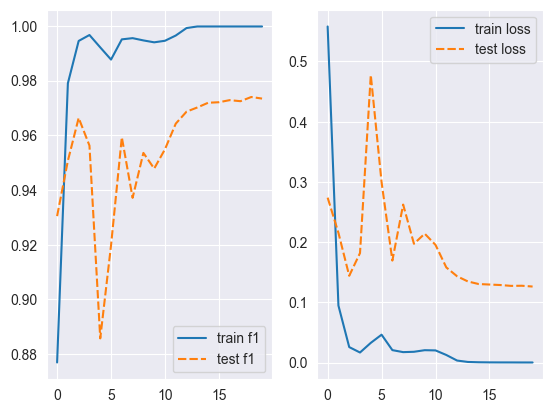

In [16]:
epochs = 20
metrics = [0] * epochs
best_loss = float('+inf')
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    metrics[t] = train(train_dataloader, model, loss_fn, optimizer) + test(test_dataloader, model, loss_fn)
    torch.save(model.state_dict(), 'model.pth')
    if metrics[t][-1] < best_loss:
        best_loss = metrics[t][-1]
        torch.save(model.state_dict(), 'best_model.pth')
    # scheduler.step()
print("Done!")
metrics = np.array(metrics)
fig, ax = plt.subplots(1, 2)
sns.lineplot(data=pd.DataFrame(metrics[:, ::2], columns=['train f1', 'test f1']), ax=ax[0])
sns.lineplot(data=pd.DataFrame(metrics[:, 1::2], columns=['train loss', 'test loss']), ax=ax[1])
print(f'Best loss: {best_loss}')

In [17]:
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

Get names of classes

In [18]:
path = 'train/simpsons_dataset/'
classes = np.array(sorted([i for i in os.listdir(path) if os.path.isdir(os.path.join(path, i))]))
classes

array(['abraham_grampa_simpson', 'agnes_skinner',
       'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson',
       'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum',
       'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel',
       'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson',
       'kent_brockman', 'krusty_the_clown', 'lenny_leonard',
       'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson',
       'martin_prince', 'mayor_quimby', 'milhouse_van_houten',
       'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz',
       'otto_mann', 'patty_bouvier', 'principal_skinner',
       'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum',
       'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird',
       'troy_mcclure', 'waylon_smithers'], dtype='<U24')

Predict 

In [19]:
path = 'testset/'
pred_data = datasets.ImageFolder(path, transform=transform)
pred_dataloader = DataLoader(pred_data, batch_size=1)

model.eval()
with torch.no_grad():
    y_pred = [''] * len(pred_dataloader)
    for batch, (X, y) in enumerate(tqdm(pred_dataloader)):
        X = X.to(torch.float).to(device)
        y_pred[batch] = classes[model(X)[0].argmax(0)]
y_pred

['nelson_muntz',
 'bart_simpson',
 'ned_flanders',
 'chief_wiggum',
 'apu_nahasapeemapetilon',
 'kent_brockman',
 'edna_krabappel',
 'chief_wiggum',
 'lisa_simpson',
 'kent_brockman',
 'lenny_leonard',
 'marge_simpson',
 'kent_brockman',
 'ned_flanders',
 'moe_szyslak',
 'comic_book_guy',
 'abraham_grampa_simpson',
 'edna_krabappel',
 'kent_brockman',
 'lisa_simpson',
 'marge_simpson',
 'nelson_muntz',
 'comic_book_guy',
 'mayor_quimby',
 'homer_simpson',
 'apu_nahasapeemapetilon',
 'krusty_the_clown',
 'krusty_the_clown',
 'ned_flanders',
 'edna_krabappel',
 'apu_nahasapeemapetilon',
 'chief_wiggum',
 'apu_nahasapeemapetilon',
 'ned_flanders',
 'marge_simpson',
 'abraham_grampa_simpson',
 'homer_simpson',
 'sideshow_bob',
 'lisa_simpson',
 'charles_montgomery_burns',
 'chief_wiggum',
 'kent_brockman',
 'abraham_grampa_simpson',
 'milhouse_van_houten',
 'lenny_leonard',
 'abraham_grampa_simpson',
 'nelson_muntz',
 'comic_book_guy',
 'chief_wiggum',
 'nelson_muntz',
 'mayor_quimby',
 'c

Make submission

In [20]:
submit = pd.read_csv('sample_submission.csv')
submit['Id'] = np.array(pred_data.imgs)[:, 0]
submit['Id'] = submit['Id'].apply(lambda x: x.split('/')[-1])
submit['Expected'] = y_pred
submit.to_csv('submission.csv', index=False)
submit

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,nelson_muntz
987,img988.jpg,ned_flanders
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,chief_wiggum
